# Histogram Equilization and Histogram Specification

### Utils

In [1]:
#taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1gCiAZnEiEzOsrfU97Z7lk0pjDhiBnfF0'
destination = '/content/dataset.zip'
download_file_from_google_drive(file_id, destination)

In [2]:
!unzip -q dataset.zip
!rm -rf dataset.zip

In [3]:
import cv2
import matplotlib.pyplot as plt

def load_image(number):
  img = cv2.imread(f"/content/original_images/img{number}.bmp")
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return gray

def show_image(image):
  plt.figure(figsize=(12,5))
  plt.imshow(image,cmap='gray')
  plt.axis('off')
  plt.show()

def calculate_hist(gray):
  fig,ax = plt.subplots(1,2,figsize=(15,5))
  ax[0].imshow(gray,cmap="gray")
  ax[0].axis('off')
  ax[0].set_title("Image")

  ax[1].hist(gray.ravel(), bins=32, range=(0.0, 256.0), ec='k') #calculating histogram
  ax[1].set_title("Histogram")
  ax[1].set_xlabel("range")
  plt.show()

def compare_matched_hist(src,dst,matched_src):
  images = [src,dst,matched_src]
  headings = ["Source","Destination","Matched Source"]
  n,m = len(images),2
  fig,ax = plt.subplots(n,m,figsize=(15,10))

  for i, (heading,img) in enumerate(zip(headings,images)):
    ax[i,0].imshow(img,cmap="gray")
    ax[i,0].axis('off')
    ax[i,0].set_title(heading)

    ax[i,1].hist(img.ravel(), bins=32, range=(0.0, 256.0), ec='k') #calculating histogram
  plt.show()

## Histogram Equalizing


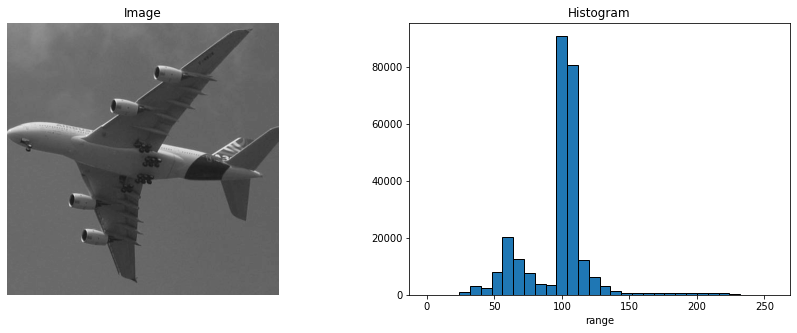

In [4]:
gray = load_image(3)
calculate_hist(gray)

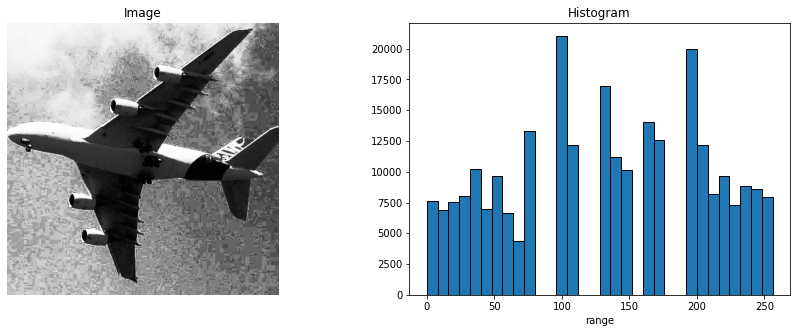

In [5]:
equalized_gray = cv2.equalizeHist(gray)
calculate_hist(equalized_gray)

In [6]:
#Importing libraries

from numba import jit
import numpy as np

In [7]:
@jit(nopython=True,cache=True)
def hist(src,h,w):
    """
    :param src: input image
    :param h: height of input image
    :param w: width of input image
    :return img_hist: histogram of input image
    """

    # Initialize result
    img_hist = np.zeros((256))

    # Calculate the image histogram
    for i in range(0,h):
        for j in range(0,w):
            img_hist[src[i,j]] += 1

    return img_hist


@jit(nopython=True,cache=True)
def cumulative_sum(img_hist):
    """
    :param img_hist: histogram of input image
    :return cdf: cdf of histogram
    """

    # Initialize result
    cdf = img_hist.copy()

    # Calculate cdf
    for i in range(1,256):
        cdf[i] = cdf[i-1] + cdf[i]

    return cdf

@jit(nopython=True,cache=True)
def eq_hist(cdf,h,w):
    """
    :param cdf: cdf of histogram
    :param h: height of input image
    :param w: width of input image
    :return result: equalized histogram
    """

    # Initialize result
    result = np.zeros((256))

    # Find non zero minimum value of cdf
    cdf_min = np.min(cdf[np.nonzero(cdf)])
    
    # Equalize histogram
    for i in range(0,256):
        result[i] = round(((cdf[i] - cdf_min)*254)/((h*w) - cdf_min)) + 1

    return result


@jit(nopython=True,cache=True)
def my_equalizing_histograms(src):
    """
    :param src: input image
    :rtype: image 
    :return dest: histogram equalized src image
    """

    # Initialize result
    dest = src.copy()

    # Height and width of image
    h,w = src.shape

    # Calculate image histogram
    img_hist = hist(dest,h,w)

    # Calculate cdf
    cdf = cumulative_sum(img_hist)

    # Equalize histogram
    result = eq_hist(cdf,h,w)

    # Create image
    for i in range(0,h):
        for j in range(0,w):
            dest[i,j] = result[src[i,j]]

    return dest

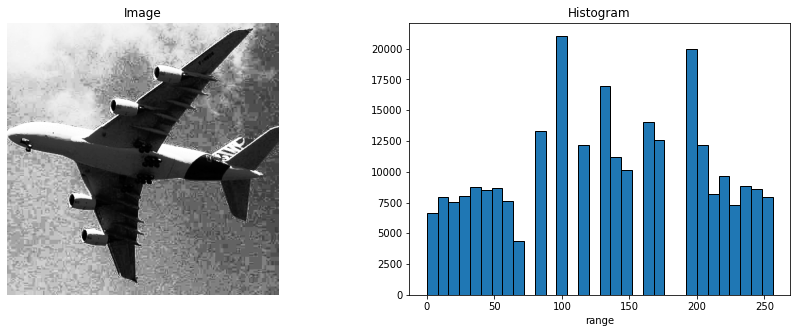

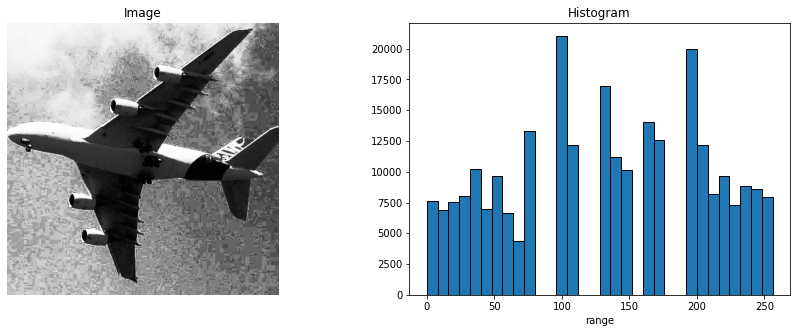

In [8]:
result = my_equalizing_histograms(gray.copy())

# Plot implemented code
calculate_hist(result)

# Plot inbuilt function
calculate_hist(equalized_gray)

### **Comparison** <br>

The inbuilt and the code produce almost the same output image. The similarity between them can be seen using the provided function `calculate_hist`. The histograms for both the inbuilt and the code have the same frequency values at the same bins when plotted with few deviations. The deviations occur because the inbuilt library may choose to ceil or floor the individual pixel values while in the code the pixel values are rounded to the nearest integer. Even with the deviations, the results are in accordance with the desired output from the inbuilt functions. Thus, the code reproduces the method of histogram equalization as implemented in the inbuilt library `cv2.equalizeHist`. 

## Histogram Matching

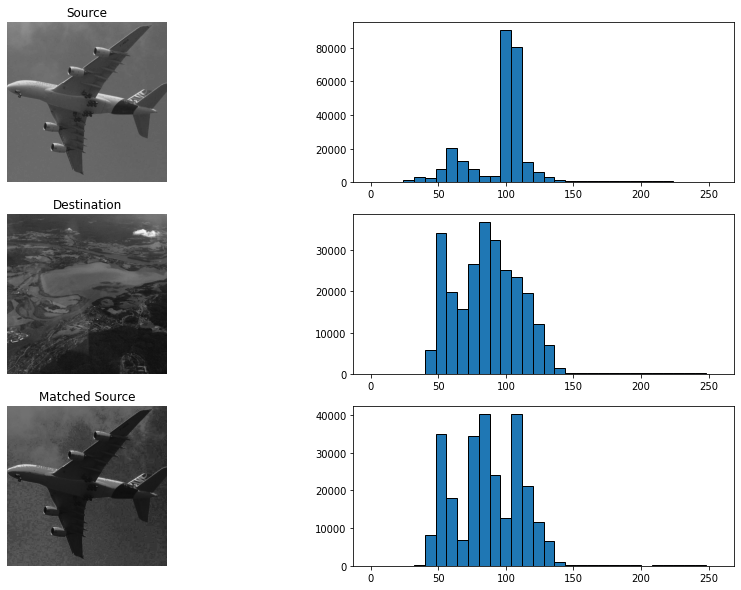

In [9]:
from skimage import exposure

src = load_image(3)
dst = load_image(4)
matched_src = exposure.match_histograms(src,dst)

compare_matched_hist(src,dst,matched_src)

In [10]:
@jit(nopython=True,cache=True)
def hist(src,h,w):
    """
    :param src: input image
    :param h: height of input image
    :param w: width of input image
    :return img_hist: histogram of input image
    """

    # Initialize result
    img_hist = np.zeros((256))

    # Calculate histogram
    for i in range(0,h):
        for j in range(0,w):
            img_hist[src[i,j]] += 1

    return img_hist


@jit(nopython=True,cache=True)
def cumulative_sum(img_hist):
    """
    :param img_hist: histogram of input image
    :return cdf: cdf of histogram
    """

    # Initialize result
    cdf = img_hist.copy()

    # Calculate cdf
    for i in range(1,256):
        cdf[i] = cdf[i-1] + cdf[i]

    return cdf


@jit(nopython=True,cache=True)
def match_hist(src_cdf,dst_cdf):
    """
    :param src_cdf: cdf of source image
    :param dst_cdf: cdf of reference image
    :return result: matched histogram
    """

    # Initialize result
    result = np.zeros((256))

    # Match histogram
    for i in range(0,256):
      j = 255

      while (j > 0 and src_cdf[i] <= dst_cdf[j]):
          j -= 1

      result[i] = j

    return result


@jit(nopython=True,cache=True)
def my_matching_histograms(src,dst):
    """
    :param src: input image
    :param dst: reference image
    :rtype: image 
    :return mathced_src: histogram matched src image
    """

    # Initialize result
    my_matched_src = src.copy()
    src_h,src_w = src.shape
    dst_h,dst_w = dst.shape

    # Calculate image histogram
    src_hist = hist(src,src_h,src_w)
    dst_hist = hist(dst,dst_h,dst_w)

    # Calculate cdf
    src_cdf = cumulative_sum(src_hist)/(src_h*src_w)
    dst_cdf = cumulative_sum(dst_hist)/(dst_h*dst_w)

    # Match histogram
    result = match_hist(src_cdf,dst_cdf)

    # Create image
    for i in range(0,src_h):
        for j in range(0,src_w):
            my_matched_src[i,j] = result[my_matched_src[i,j]]

    return my_matched_src

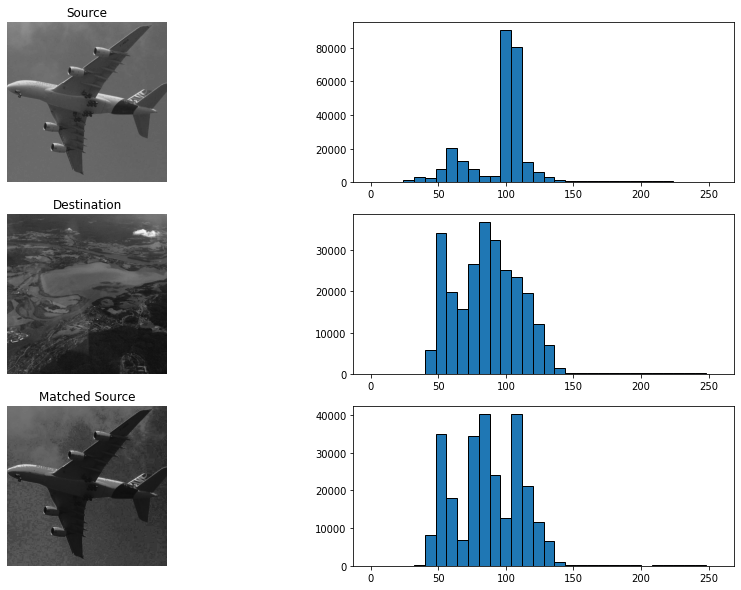

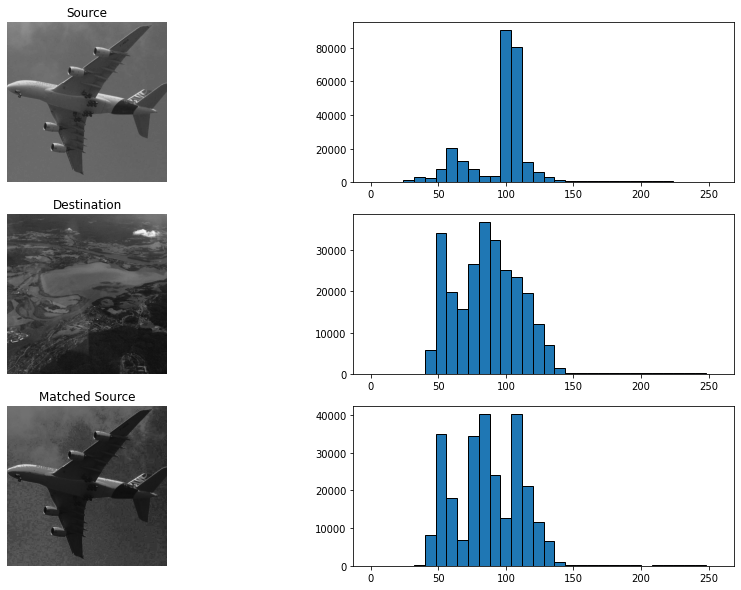

In [11]:
result = my_matching_histograms(src,dst)

# Plot implemented code
compare_matched_hist(src,dst,result)

# Plot inbuilt function
compare_matched_hist(src,dst,matched_src)

### **Comparison** <br>

The inbuilt and the code produce almost the same output image. The similarity between them can be seen using the provided function `compare_matched_hist`. The histograms for both the inbuilt and the code have the same frequency values at the same bins when plotted. Thus, the code reproduces the method of histogram matching as implemented in the inbuilt library `exposure.match_histograms`. 

In [12]:
src = load_image(1)
dst = load_image(2)

In [13]:
%%timeit

my_equalizing_histograms(src)
my_matching_histograms(src,dst)

1000 loops, best of 5: 1.7 ms per loop
